In [15]:
from IPython.core.display import HTML
HTML(""" <link href="https://fonts.googleapis.com/css2?family=Inter:wght@600&family=Noto+Sans+JP&display=swap" rel="stylesheet"> 
<style>
    div.text_cell_render h1 {
        font-family: 'Inter';
        font-size: 1.7em;
        line-height:1.4em;
        text-align:center;
        }

    div.text_cell_render { 
        font-family: 'Noto Sans JP';
        font-size:1.05em;
        line-height:1.5em;
        padding-left:3em;
        padding-right:3em;
        }
</style>""")

# Analyzing the Data

After downloading and structuring the data in the previous notebooks, this notebook discusses the analysis of the data. First, metadata analysis is explained. This entails the aggregation and visualization of:
- the number of webpages through time
- the most frequent top level domains (through time)
- the distribution of languages (through time)

After working with the metadata, the notebook explains three ways of analyzing the textual content of the pages. This includes the aggregation and visualization of:
- the most frequent words found on the webpages (hereby differentiating between languages)
- the most topical words for every document, through the TFIDF statistic
- the words that co-occur frequently with a keyword, through the PMI statistic

# Gathering the Data
In the previous notebooks, various types of data were downloaded and parsed. The webpages are in the ```html``` folders, the dates and languages are stored in ```.json``` files, similar to the webpage text. Analyzing the data requires the combination of data types. For that reason, it is useful to gather the data in one place. Below the data stored in different locations is imported into Python. Subsequently, it is combined in one, single "dataframe". A dataframe is a Python object that contains data. It is comparable to an Excel table. In fact, dataframes can be exported to Excel or .csv (comma-separated) files. Moreover, dataframes are easy to query and visualizing the data stored in dataframes is easy to do with the popular dataframe library Pandas. 

In [2]:
import os
import json
import re
#from purl import URL
import pandas as pd
import langid
import matplotlib.pyplot as plt

In [3]:
base_path = "D:/react-data/test"

'''
Import the dates from the dates.txt file in the photo folder. The dates.txt file contains the URL and the associated date, separated by '||'.
If we split the strings on these characters, we get URL-date pairs. These are then stored in a dictionary: another popular Python object that 
can be compared to a .json file. 
'''
dates_dictionary = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_dictionary.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

'''
Import that languages from the languages-photo.json file. Here we do a similar thing: import the .json file and store the identifier - language pairs
in a dictionary. 
'''
language_dictionary = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    with open(os.path.join(photo_folder,'languages-'+photo+".json"),'r') as f:
        lang = json.load(f)
    
    languages = []
    
    for iterkey,items1 in lang.items():
        
        for id_, lan_items in items1.items():
            language = lan_items[0] # the language identifier also outputs the probability that the guess is right. We don't need that so we discard it here
            language_dictionary.update({id_:language})
                
'''
Import texts from parsed_text.json file in iteration folders. N.B.: this means that for every iteration one .json with texts is constructed.
Hence the extra loop. This loop also combines all the information in one object. In this process we also extract the so-called Top Level
Domain (TLD), for example www.facebook.com in the case of the URL www.facebook.com/user/something. 
'''
text_dictionary = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    num_iterations = len(num_iterations)

    start_iter = 1
    range_iter = [str(i) for i in list(range(1,num_iterations + 1))]

    folder_base = os.path.join(base_path,photo,photo)

    for iteration in range_iter:
        fn = os.path.join(folder_base + "_" +str(iteration),"txt", "parsed_text.json")
        with open(fn) as fp:
            pages = json.load(fp)
            
        for identifier,sentences in pages.items():
            
            sentences = [s.replace("\n","").lower() for s in sentences]
            sentences = [re.sub(' +', ' ', s) for s in sentences]

            url = identifier.split('html_')[-1]
            id_ = identifier.split('/html/')[1].split('.html_')[0]
            if url in dates_ref.keys():
                date = dates_dictionary[url]
            else:
                date = "na"
            
            text_dictionary.update({identifier:dict()})
            text_dictionary[identifier].update({"photo":photo,"url":url,"identifier":id_,"date":date,"language":language_dictionary[url],"sentences":"||".join(sentences)})

In [4]:
'''
Here we transform the constructed dictionary is a DataFrame that can be exported to a .csv file. To be sure that there are no duplicate pages in our dataset
we remove the duplicates.
'''

df = pd.DataFrame.from_dict(text_ref,orient='index').reset_index()
df = df.drop_duplicates('url',keep='first')
df.columns = ["path","photo","url","identifier","date","language","sentences"]
#df.to_csv('path/to/datafolder/data-full.csv',index=False)
data = df

# Analysis Part 1. Diachronic Frequency

We now have a dataframe where every row represents a webpage. The columns contain information about the path to the webpage text, the name of the photo, the URL, the identifier, the date, the language and the actual text. 

With the data stored in such a format, it is relatively straightforward to study some basic frequential patterns (although the Pandas dataframe syntax can be a bit overwhelming at first. We start by plotting the number of webpages in every year.

In [5]:
#data = pd.read_csv('path/to/datafolder/data-full.csv')

subset = data[['photo','date']] # get the photo and date columns from the Pandas dataframe stored in the 'data' variable
subset['count'] = 1 # add a count column, because every row is one observation (this comes in useful later)

# loop over the dates and if the date is not "na" or "nan": extract the year (the first 4 characters of the date)
subset['year'] = ''

for c,i in enumerate(subset['date']):
    
    if "na" not in str(i): # 
        year = str(i)[0:4]
        subset['year'][c] = year
    else:
        subset['year'][c] = "na"
        
# Remove all observations with "na"
subset = subset[~subset['year'].isin(["na","nan"])]

# Group by photo and year and add the values
subset = subset.groupby(['photo','year']).sum().reset_index()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

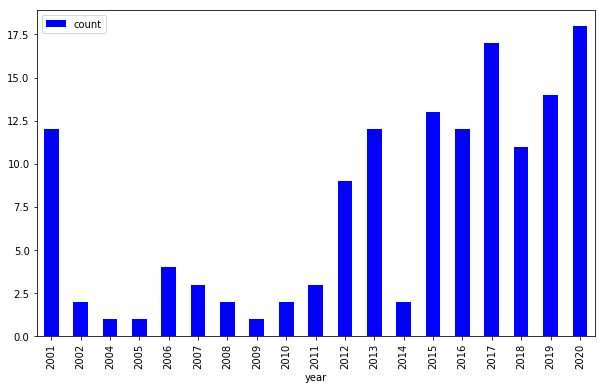

In [6]:
'''
Now we have a dataframe that has three columns: the name of the photo, the year and the webpage frequency. Now it is possible to plot the data.
If you used only one photo you can simply plot the years against the frequency:
'''
p = subset.plot.bar(x='year',y='count',figsize=(10,6), color='b')
plt.show()

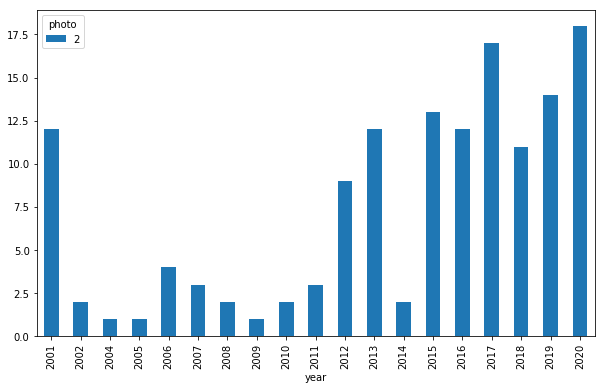

In [7]:
'''
If you have multiple photos, mutate the dataframe in such a way that it has the following column structure:

year | photo_name_1 | photo_name_2
1999 | 4            | 55

This operation also works if you have one photo, so you can safely run this cell
'''

subset = subset.pivot(index='year',columns='photo',values='count').reset_index()
p = subset.plot.bar(x='year',y=list(subset.columns)[1:],figsize=(10,6))
plt.show()

# Analysis Part 2. Top Level Domains

The URLs that refer to the pages were the image is found are highly specific. They consist of several compontents: 
- the "http" component that indicates the use of the Hypertext Transfer Protocol, a set of rules for web traffic
- the "www" component that indicates that the page is on the World Wide Web
- the "top level domain" ("facebook", "bbc", "twitter") the name of the website
- a domain extension (".nl",".com") 
- a "path" that refers to specific data or pages on the website 

Especially the top level domains (TLDs) and the extensions can help in identifying frequently occuring websites. To extract the TLDS we use an existing URL-parser, a Python module that identifies the parts of the URL.

To extract the TLDs we use something called "list comprehension". This is a very effective way of doing things with lists. Imagine the following list: ```[1,2,3,4,5]```, stored in the variable ```list1```. The list elements can be shown by doing ```[item for item in list1]```. Once we know this, we could also do ```[item + 1 for item in list1]```, which results in ```[2,3,4,5,6]```. In fact, we could do anything in this way. Below we use the ```URL.from_string(x).domain()``` function to extract the TLDs.

Next, we use a very handy module called ```Counter()``` to get the most frequent TLDs.

In [8]:
from collections import Counter

In [50]:
tlds = [URL.from_string(u).domain() for u in list(set(data['url']))]
Counter(tlds).most_common(15)

[('wikivisually.com', 6),
 ('twitter.com', 6),
 ('genius.com', 5),
 ('www.pinterest.com', 4),
 ('scalar.usc.edu', 4),
 ('www.liberties.eu', 4),
 ('www.revolvy.com', 4),
 ('m.dagospia.com', 4),
 ('gramho.com', 4),
 ('omonoianews.com', 3),
 ('www.tapatalk.com', 3),
 ('www.liberoquotidiano.it', 3),
 ('www.picuki.com', 2),
 ('bellerofonte.blogspot.com', 2),
 ('indicator.gr', 2)]

# Analysis Part 3. Languages

We already know something of the languages by looking at the extensions. A better way to look at the distribution of languages is identifying the language of the webpage text itself. Luckily, several Python modules are able to identify the language of a text. In the previous notebook, we used ```langid.classify()``` to identify languages. Since it is very fast, we repeat this here. Because the classifier also outputs the probability of a correct guess (which is always very high because we have lots of textual data) we have to select the first element from its output (```identifier.classify('example webpage text')[0]```)

In [9]:
from collections import Counter
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

data['language'] = [identifier.classify(x)[0] for x in list(data['sentences'])]

In [17]:
'''
Now we use Counter() to find the language distribution
'''

Counter(list(data['language'])).most_common(15)

[('en', 57),
 ('it', 53),
 ('tr', 9),
 ('el', 8),
 ('es', 8),
 ('nl', 6),
 ('fr', 4),
 ('eo', 3),
 ('pt', 3),
 ('ko', 1),
 ('da', 1),
 ('zh', 1),
 ('hu', 1),
 ('ru', 1),
 ('bs', 1)]

# Text Analysis

So far we have worked with the metadata. The contents of the webpages are also a valuable source of information. This is where we move into the area of text analysis. In this notebook we will work on the basic unit of text analysis: word counts.

Before we can count words, we need to again reformat the data. This involves several steps:
- removing the '||' separators we used in the parsing
- splitting the web page text into tokens. Tokens are "an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing" ([Stanford NLP](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html)). This often translates into words, but a "." or a "&" is also identified as a token. For the tokenization of the data we use the powerful ```nltk``` (Natural Language Toolkit).

Also, we cannot really compare words in multiple languages, so we first subset a dataset with a language of your choice (in the example it is italian, marked as 'it')

In [10]:
import nltk

In [11]:
texts_subset = data[data['language']=='it']['sentences']
texts_subset = [t.replace('||','') for t in texts_subset]
texts_subset = [nltk.word_tokenize(t) for t in texts_subset]

# Merge all the webpages into one 'Bag of Words' using a more complex form of list comprehension (that 'flattens' a list of lists)
subset_bow = [word for webpage in texts_subset for word in webpage]

# find the most frequent words
Counter(subset_bow).most_common(15)

[(',', 2645),
 ('di', 1337),
 ('e', 823),
 ('che', 743),
 ('la', 618),
 ('in', 612),
 ('il', 592),
 ('’', 564),
 ('a', 557),
 ('un', 555),
 ('per', 504),
 ('non', 444),
 ('è', 399),
 ('del', 394),
 ('una', 324)]

The words shown above do not come as a surprise. Words like 'the' and 'a' occur numerous times and do not tell us anything about the semantic content of the webpages. One way to come closer to the contents of the pages is to remove frequently occuring 'stopwords'. This can also be done with ```nltk```.

In [12]:
from nltk.corpus import stopwords
subset_bow_nostops = [word for word in subset_bow if word not in stopwords.words('italian') and len(word) > 2] #replace italian by "english" or "french"

In [13]:
Counter(subset_bow_nostops).most_common(15)

[('stato', 119),
 ('giuliani', 113),
 ('carlo', 110),
 ('anni', 86),
 ('fatto', 82),
 ('due', 70),
 ('genova', 67),
 ('vita', 64),
 ('solo', 59),
 ('parte', 53),
 ('ancora', 52),
 ('dopo', 50),
 ('fare', 50),
 ('senza', 49),
 ('poi', 49)]

The words that appear in the list after removing the stopwords are already more indicative of the contents of the webpage. Word frequencies are the building blocks of many other methods. Two of them are particularly useful and will be introduced in the remainder of this notebook.

One useful measure is "Term Frequency Inverted Document Frequency" (TFIDF). This measure calculates the likelihood that a word appears in a document and multiplies this term frequency (TF) by the Inverted Document Frequency (IDF), that is: (the log of) the number of documents divided by the number of documents that contain a specific word. This can be used to check which words appear in a document, thereby taking into account the frequency of that word in the whole corpus. If the word "protest" occurs frequently on one webpage, but not very frequently on other pages, it will have a high TFIDF score.

In [48]:
# Get a list of the unique words, excluding stopwords
unique_words = list(set(subset_bow_nostops)) 

# Create a dataframe
term_frequency = []

for word in unique_words:
    
    for document_number,webpage in enumerate(texts_subset): #we already made texts_subset:
            word_frequency_document = len([w for w in webpage if w == word]) / len(webpage)
            tmp = [document_number,word,word_frequency_document] # make a list of the webpagename, word and the frequency of the word on the page
            term_frequency.append(tmp)

In [49]:
import math

document_frequency = dict()

for word in unique_words:
    doc_freq = len([webpage for webpage in texts_subset if word in webpage])
    inverse_doc_freq = math.log(len(texts_subset) / doc_freq)  
    document_frequency.update({word:doc_freq})

In [50]:
tfidf_list = []

for document_number,word,word_frequency_document in term_frequency:
    tfidf_score = word_frequency_document * document_frequency[word]
    tfidf_list.append([document_number,word,tfidf_score])

In [51]:
tfidf = pd.DataFrame(tfidf_list,columns=['doc','word','tfidf']) # make a dataframe
tfidf = tfidf.pivot(index='word',columns='doc',values='tfidf') # transform the "long" dataframe to a "wide" one

In [62]:
tfidf.sort_values(2,ascending=False)[0][0:10] # select document 2, sort the largest values and select column 2 (corresponds with document 2)

word
anni        0.000000
corte       0.000000
stato       0.814815
genova      0.000000
due         0.271605
oggi        0.000000
luglio      0.197531
italiana    0.000000
dopo        0.000000
ancora      0.000000
Name: 0, dtype: float64

# Pointwise Mutual Information

TFIDF is great for investigating differences between web pages or even clustering them together. However, for many research questions we are actually interested in the 'behaviour' of specific words. One way of investigating single words is collocation analysis. Here, we evaluate which words often co-occur in the same sentence. A formal statistic for collocation analysis is PMI (Pointwise Mutual Information). Here, we calculate the probability of the target word (example: "protest). This probability is calculated by taking the frequency of "protest" in the corpus and sharing that by the number of words in the corpus. Subsequently, we select another word (example: "violence"). We calculate the probability that the two words appear together. What "together" means is up to you. It is good practice to take the sentence as a measure for togetherness. In other words, we identify the sentences (with ```nltk.sent_tokenize()```), count the number of co-occurrences and share this frequency by the number of sentences. Lastly, we take the log of P(x,y) / P(x) * P(y) in order to normalize the effect of frequency, similar to TFIDF.

To put it in mathematical terms: "The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence".


In [ ]:
term_frequency = dict()

# Create a dataframe
term_frequency = []

for word in unique_words:
    
    for document_number,webpage in enumerate(texts_subset): #we already made texts_subset:
            word_frequency_document = len([w for w in webpage if w == word]) / len(webpage)
            tmp = [document_number,word,word_frequency_document] # make a list of the webpagename, word and the frequency of the word on the page
            term_frequency.append(tmp)

sentences = [nltk.sent_tokenize(d) for d in all_docs]
sentences = [item for sublist in sentences for item in sublist]
print("Number of Sentences: {}".format(len(sentences)))

# Get PMI values
for kw in keywords:
    pmi_d = []
    p_keyword = len([s for s in sentences if kw in s.split(' ')]) / len(sentences) * 100

    for w in target_word_dict[kw]:
        ntarget = len([s for s in sentences if w in s.split(' ')])
        nxy = len([s for s in sentences if w in s and kw in s.split(' ')])

        if ntarget < threshold or nxy < threshold:
            continue

        ptarget = len([s for s in sentences if w in s]) / len(sentences) * 100
        pxy = len([s for s in sentences if w in s and kw in s]) / len(sentences) * 100


        if len([s for s in sentences if w in s and kw in s]) > 0:
            pmi = math.log((pxy) / (ptarget * p_keyword))
            pmi_d.append([w,pmi,ntarget,nxy])
        else:
            continue
    if len(pmi_d) > 0:
        t = pd.DataFrame(pmi_d,columns = ['w','s','ntarget','ntogether'])
        t.to_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_carlo/pmi-{}-en.csv'.format(kw),index=False)
    else:
        print("{} has no PMI candidates that meet the threshold".format(kw))